# Tutorial 3: How simulations define your predictions
The inverse problem has no unique solution as it is ill-posed. In order to solve it we need to constraint the space of possible solutions. While inverse solutions like minimum-norm estimates have an explicit constraint of minimum-energy, the constraints with esinet are implicit and mostly shaped by the simulations.

This tutorial aims the relation between simulation parameters and predictions.

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

# import mne
# import numpy as np
# from copy import deepcopy
# import matplotlib.pyplot as plt
import sys; sys.path.insert(0, '../')
from esinet import util
from esinet import Simulation
from esinet import Net
from esinet.forward import create_forward_model, get_info
from scipy.stats import pearsonr
from matplotlib import pyplot as plt
plot_params = dict(surface='white', hemi='both', verbose=0)

## Create Forward model
First we create a template forward model which comes with the esinet package

In [2]:
info = get_info(sfreq=100)
fwd = create_forward_model(sampling="ico3", info=info)

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    1.9s remaining:    3.3s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    1.9s remaining:    1.1s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   3 out of   8 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=8)]: Done   5 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.1s finished


# Simulate

## defs

In [37]:
import numpy as np
import tensorflow as tf
import mne
def prep_data(sim):
    X = np.squeeze(np.stack([eeg.average().data for eeg in sim.eeg_data]))
    X = np.stack([(x - np.mean(x)) / np.std(x) for x in X], axis=0)
    y = np.squeeze(np.stack([src.data for src in sim.source_data]))
    y = np.stack([(x / np.max(abs(x))) for x in y], axis=0)

    if len(X.shape) == 2:
        X = np.expand_dims(X, axis=-1)
        y = np.expand_dims(y, axis=-1)
    X = np.swapaxes(X, 1,2)
    y = np.swapaxes(y, 1,2)
    return X, y

def sparsity(y_true, y_pred):
    return K.mean(K.square(y_pred)) / K.max(K.square(y_pred))
def custom_loss():
    def loss(y_true, y_pred):
        loss1 = tf.keras.losses.CosineSimilarity()(y_true, y_pred)
        loss2 = sparsity(None, y_pred)
        return loss1 + loss2 * 1e-3
    return loss

from esinet.evaluate import auc_metric, eval_auc, eval_nmse, eval_mean_localization_error

def eval(y_true, y_hat):
    n_samples = y_true.shape[0]
    n_time = y_true.shape[1]
    aucs = np.zeros((n_samples, n_time))
    mles = np.zeros((n_samples, n_time))
    nmses = np.zeros((n_samples, n_time))
    for i in range(n_samples):
        for j in range(n_time):
            aucs[i,j] = np.mean(eval_auc(y_true[i,j], y_hat[i,j], pos))
            nmses[i,j] = eval_nmse(y_true[i,j], y_hat[i,j])
            mles[i,j] = eval_mean_localization_error(y_true[i,j], y_hat[i,j], pos)

    return aucs, nmses, mles

def threshold_activation(x):
    return tf.cast(x > 0.5, dtype=tf.float32)

class Compressor:
    ''' Compression using Graph Fourier Transform
    '''
    def __init__(self):
        pass
    def fit(self, fwd, k=600):
        A = mne.spatial_src_adjacency(fwd["src"], verbose=0).toarray()
        D = np.diag(A.sum(axis=0))
        L = D-A
        U, s, V = np.linalg.svd(L)

        self.U = U[:, -k:]
        self.s = s[-k:]
        self.V = V[:, -k:]
        return self
        
    def encode(self, X):
        ''' Encodes a true signal X
        Parameters
        ----------
        X : numpy.ndarray
            True signal
        
        Return
        ------
        X_comp : numpy.ndarray
            Compressed signal
        '''
        X_comp = self.U.T @ X

        return X_comp

    def decode(self, X_comp):
        ''' Decodes a compressed signal X

        Parameters
        ----------
        X : numpy.ndarray
            Compressed signal
        
        Return
        ------
        X_unfold : numpy.ndarray
            Decoded signal
        '''
        X_unfold = self.U @ X_comp
        return X_unfold

## sim

In [4]:
n_samples = 5000
settings = dict(duration_of_trial=0.25, extents=(1,40), number_of_sources=(1,15), target_snr=(2, 15))
sim = Simulation(fwd, info, settings=settings).simulate(n_samples=n_samples)
X, y = prep_data(sim)

Simulating data based on sparse patches.


100%|██████████| 5000/5000 [01:01<00:00, 81.52it/s]


# GFT

In [5]:
# comp = Compressor()
# comp.fit(fwd)
# y_comp = np.stack([comp.encode(yy.T).T for yy in y], axis=0)

y_comp = y

# %matplotlib qt
# plt.figure()
# plt.imshow(y[0], aspect=y[0].shape[1] / y[0].shape[0])
# plt.figure()
# plt.imshow(y_comp[0], aspect=y_comp[0].shape[1] / y_comp[0].shape[0])

# LSTM

In [8]:
len(sim.eeg_data[0].ch_names)

61

In [24]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, TimeDistributed, Bidirectional, LSTM, GRU, multiply, add, Activation, Dropout
from tensorflow.keras.regularizers import l1
from esinet.losses import nmse_loss, nmae_loss

leadfield, pos = util.unpack_fwd(fwd)[1:3]
n_channels, _ = leadfield.shape
n_dipoles = y_comp.shape[-1]
input_shape = (None, None, n_channels)
tf.keras.backend.set_image_data_format('channels_last')

n_dense_units = 61
n_lstm_units = 32
activation_function = "tanh"
batch_size = 32
epochs = 30
dropout = 0.2
input_dropout = 0.1

inputs = tf.keras.Input(shape=(None, n_channels), name='Input')

fc1 = TimeDistributed(Dense(n_dense_units, 
            activation=activation_function), 
            name='FC1')(inputs)
fc1 = Dropout(dropout)(fc1)

direct_out = TimeDistributed(Dense(n_dipoles, 
            activation="linear"),
            name='FC2')(fc1)

lstm1 = Bidirectional(GRU(n_lstm_units, return_sequences=True, 
            input_shape=(None, n_dense_units), dropout=dropout), 
            name='LSTM1')(fc1)
# lstm1 = Bidirectional(GRU(n_lstm_units, return_sequences=True, 
#             input_shape=(None, n_dense_units), dropout=dropout), 
#             name='LSTM2')(lstm1)
mask = TimeDistributed(Dense(n_dipoles, 
            activation="sigmoid"), 
            name='Mask')(lstm1)
multi = multiply([direct_out, mask], name="multiply")
model = tf.keras.Model(inputs=inputs, outputs=multi, name='Contextualizer')


model.compile(loss=tf.keras.losses.CosineSimilarity(), optimizer="adam")
# model.compile(loss=tf.keras.losses.Huber(), optimizer="adam", metrics=[tf.keras.losses.CosineSimilarity()])


model.summary()
for _ in range(5):
    model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.15)
    n_samples = 5000
    settings = dict(duration_of_trial=0.25, extents=(1,40), number_of_sources=(1,15), target_snr=(2, 15))
    sim = Simulation(fwd, info, settings=settings).simulate(n_samples=n_samples)
    X, y = prep_data(sim)

Note that input tensors are instantiated via `tensor = tf.keras.Input(shape)`.
The tensor that caused the issue was: dropout_9/Identity:0


ValueError: Graph disconnected: cannot obtain value for tensor KerasTensor(type_spec=TensorSpec(shape=(None, None, 61), dtype=tf.float32, name='Input'), name='Input', description="created by layer 'Input'") at layer "dropout_9". The following previous layers were accessed without issue: []

In [35]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, TimeDistributed, Bidirectional, LSTM, GRU, multiply, add, Activation, Dropout
from tensorflow.keras.regularizers import l1
from esinet.losses import nmse_loss, nmae_loss

leadfield, pos = util.unpack_fwd(fwd)[1:3]
n_channels, _ = leadfield.shape
n_dipoles = y_comp.shape[-1]
input_shape = (None, None, n_channels)
tf.keras.backend.set_image_data_format('channels_last')

n_dense_units = 256
n_lstm_units = 64
activation_function = "tanh"
batch_size = 32
epochs = 30
dropout = 0.2
input_dropout = 0.1

inputs = tf.keras.Input(shape=(None, n_channels), name='Input')

fc1 = TimeDistributed(Dense(n_dense_units, 
            activation=activation_function), 
            name='FC1')(inputs)
fc1 = Dropout(dropout)(fc1)

lstm1 = Bidirectional(GRU(64, return_sequences=True, 
            input_shape=(None, n_dense_units), dropout=dropout), 
            name='LSTM1')(inputs)
mask1 = TimeDistributed(Dense(n_dense_units, 
            activation="sigmoid"), 
            name='Mask1')(lstm1)

multi = multiply([fc1, mask1], name="multiply1")

direct_out = TimeDistributed(Dense(n_dipoles, 
            activation="linear"),
            name='FC2')(multi)

lstm2 = Bidirectional(GRU(n_lstm_units, return_sequences=True, 
            input_shape=(None, n_dense_units), dropout=dropout), 
            name='LSTM2')(multi)
# lstm2 = Bidirectional(GRU(n_lstm_units, return_sequences=True, 
#             input_shape=(None, n_dense_units), dropout=dropout), 
#             name='LSTM3')(lstm2)
mask2 = TimeDistributed(Dense(n_dipoles, 
            activation="sigmoid"), 
            name='Mask2')(lstm2)
multi = multiply([direct_out, mask2], name="multiply2")
model = tf.keras.Model(inputs=inputs, outputs=multi, name='Contextualizer')


model.compile(loss=tf.keras.losses.CosineSimilarity(), optimizer="adam")
# model.compile(loss=tf.keras.losses.Huber(), optimizer="adam", metrics=[tf.keras.losses.CosineSimilarity()])


model.summary()

n = 10
duration_of_trials = np.linspace(0,25,num=n)
n_samples = 15000

for i in range(n):
    
    settings = dict(duration_of_trial=duration_of_trials[i], extents=(1,40), number_of_sources=(1,15), target_snr=(2, 15))
    sim = Simulation(fwd, info, settings=settings).simulate(n_samples=n_samples)
    X, y = prep_data(sim)
    model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.15)
    n_samples = 5000
    

Model: "Contextualizer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              [(None, None, 61)]   0                                            
__________________________________________________________________________________________________
FC1 (TimeDistributed)           (None, None, 256)    15872       Input[0][0]                      
__________________________________________________________________________________________________
LSTM1 (Bidirectional)           (None, None, 128)    48768       Input[0][0]                      
__________________________________________________________________________________________________
dropout_17 (Dropout)            (None, None, 256)    0           FC1[0][0]                        
_____________________________________________________________________________________

100%|██████████| 15000/15000 [00:23<00:00, 631.75it/s]


AxisError: axis2: axis 2 is out of bounds for array of dimension 2

In [38]:
# settings = dict(duration_of_trial=duration_of_trials[i], extents=(1,40), number_of_sources=(1,15), target_snr=(2, 15))
#     sim = Simulation(fwd, info, settings=settings).simulate(n_samples=n_samples)
X, y = prep_data(sim)
model.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.15)
n_samples = 5000

Epoch 1/30
399/399 [==============================] - 17s 31ms/step - loss: -0.2490 - val_loss: -0.3134
Epoch 2/30
399/399 [==============================] - 11s 28ms/step - loss: -0.3348 - val_loss: -0.3631
Epoch 3/30
399/399 [==============================] - 11s 27ms/step - loss: -0.3850 - val_loss: -0.3997
Epoch 4/30
399/399 [==============================] - 11s 28ms/step - loss: -0.4267 - val_loss: -0.4304
Epoch 5/30
399/399 [==============================] - 11s 27ms/step - loss: -0.4620 - val_loss: -0.4484
Epoch 6/30
399/399 [==============================] - 11s 27ms/step - loss: -0.4883 - val_loss: -0.4573
Epoch 7/30
399/399 [==============================] - 11s 26ms/step - loss: -0.5078 - val_loss: -0.4637
Epoch 8/30
399/399 [==============================] - 11s 26ms/step - loss: -0.5257 - val_loss: -0.4688
Epoch 9/30
128/399 [========>.....................] - ETA: 6s - loss: -0.5512

KeyboardInterrupt: 

In [33]:
n_samples = 2
settings = dict(duration_of_trial=0.25, extents=(1,2), number_of_sources=6, target_snr=(2, 15))


sim_test = Simulation(fwd, info, settings=settings).simulate(n_samples=n_samples)
print(sim_test.simulation_info.number_of_sources.values[0])
X_test, y_test = prep_data(sim_test)

y_hat = model.predict(X_test)[0]

stc = sim_test.source_data[0]
stc.plot(**plot_params)

stc_hat = stc.copy()
# stc_hat.data = comp.decode(y_hat.T)
stc_hat.data = y_hat.T

stc_hat.plot(**plot_params)


Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 74.03it/s]


6


# Old LSTM

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, TimeDistributed, Bidirectional, LSTM, GRU, multiply, Activation
from tensorflow.keras.regularizers import l1
from esinet.losses import nmae_loss
leadfield, pos = util.unpack_fwd(fwd)[1:3]
n_channels, n_dipoles = leadfield.shape
input_shape = (None, None, n_channels)
tf.keras.backend.set_image_data_format('channels_last')

n_dense_units = 300
n_lstm_units = 128
activation_function = "tanh"
batch_size = 32
epochs = 30
dropout = 0.2

inputs = tf.keras.Input(shape=(None, n_channels), name='Input')
fc1 = TimeDistributed(Dense(n_dense_units, 
            activation=activation_function), 
            name='FC1')(inputs)
fc1 = Dropout(dropout)(fc1)
lstm1 = Bidirectional(GRU(n_lstm_units, return_sequences=True, name='LSTM1'))(fc1)

direct_out = TimeDistributed(Dense(n_dipoles, 
            activation="linear"),
            name='FC2')(lstm1)


model2 = tf.keras.Model(inputs=inputs, outputs=direct_out, name='LSTM_Old')


model2.compile(loss=tf.keras.losses.CosineSimilarity(), optimizer="adam")
model2.summary()
model2.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.15)

Model: "LSTM_Old"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, None, 61)]        0         
                                                                 
 FC1 (TimeDistributed)       (None, None, 300)         18600     
                                                                 
 dropout_1 (Dropout)         (None, None, 300)         0         
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        330240    
 l)                                                              
                                                                 
 FC2 (TimeDistributed)       (None, None, 1284)        329988    
                                                                 
Total params: 678,828
Trainable params: 678,828
Non-trainable params: 0
____________________________________________________

# FC

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, TimeDistributed, Bidirectional, LSTM, GRU, multiply, Activation
from tensorflow.keras.regularizers import l1
from esinet.losses import nmae_loss
leadfield, pos = util.unpack_fwd(fwd)[1:3]
n_channels, n_dipoles = leadfield.shape
input_shape = (None, None, n_channels)
tf.keras.backend.set_image_data_format('channels_last')

n_dense_units = 600
n_lstm_units = 30
activation_function = "tanh"
batch_size = 32
epochs = 30
dropout = 0.1

inputs = tf.keras.Input(shape=(None, n_channels), name='Input')
fc1 = TimeDistributed(Dense(n_dense_units, 
            activation=activation_function), 
            name='FC1')(inputs)
direct_out = TimeDistributed(Dense(n_dipoles, 
            activation="linear"),
            name='FC2')(fc1)


model3 = tf.keras.Model(inputs=inputs, outputs=direct_out, name='FC')


model3.compile(loss=tf.keras.losses.CosineSimilarity(), optimizer="adam")

model3.summary()
model3.fit(X, y, epochs=epochs, batch_size=batch_size, validation_split=0.15)

Model: "FC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, None, 61)]        0         
                                                                 
 FC1 (TimeDistributed)       (None, None, 600)         37200     
                                                                 
 FC2 (TimeDistributed)       (None, None, 1284)        771684    
                                                                 
Total params: 808,884
Trainable params: 808,884
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
399/399 [==============================] - 3s 7ms/step - loss: -0.2897 - val_loss: -0.3501
Epoch 2/30
399/399 [==============================] - 2s 5ms/step - loss: -0.3597 - val_loss: -0.3755
Epoch 3/30
399/399 [==============================] - 2s 5ms/step - loss: -0.3755 - val_loss: -0.3851
Epoch 4/30
399/3

# Eval

In [51]:
import numpy as np
from scipy.stats import pearsonr
from tqdm.notebook import tqdm
import sys; sys.path.insert(0, '../../invert/')
from invert.solvers.empirical_bayes import SolverChampagne

solver = SolverChampagne()
solver.make_inverse_operator(fwd)
n_samples = 50
settings = dict(duration_of_trial=0.25, number_of_sources=(1,10), extents=(1,40))
# settings = dict(duration_of_trial=0.25, number_of_sources=5, extents=(1,2))

sim_test = Simulation(fwd, info, settings=settings).simulate(n_samples=n_samples)
X_test, y_test = prep_data(sim_test)

# models = [model, model2, model3]
# aucs = []
# mles = []
# nmses = []
# for net in models:
#     y_hat = net.predict(X_test)
#     auc, nmse, mle = eval(y_test, y_hat)
#     aucs.append( auc )
#     nmses.append( nmse )
#     mles.append( mle )
#     print(f"{net.name}: \n\t{np.nanmedian(aucs[-1])} AUC \n\t{np.nanmedian(mles[-1])} mm \n\t{np.nanmedian(nmses[-1])} nMSE")

# y_hat = np.stack([solver.apply_inverse_operator(epochs.average()).data for epochs in tqdm(sim_test.eeg_data)], axis=0)
# y_hat = np.swapaxes(y_hat, 1, 2)
# auc, nmse, mle = eval(y_test, y_hat)
# aucs.append( auc )
# nmses.append( nmse )
# mles.append( mle )

# models.append(solver)
# print(f"{solver.name}: \n\t{np.nanmedian(aucs[-1])} AUC \n\t{np.nanmedian(mles[-1])} mm \n\t{np.nanmedian(nmses[-1])} nMSE")

idx = 0
n = sim_test.simulation_info["number_of_sources"].values[idx]
print(f"{n} sources")

# PLOTTING BRAINS
stc = sim_test.source_data[idx]
stc.plot(**plot_params, brain_kwargs=dict(title="Ground Truth"))

stc_hat = stc.copy()
y_hat = model.predict(X_test)[idx]
stc_hat.data = y_hat.T
stc_hat.plot(**plot_params, brain_kwargs=dict(title=model.name))
r = pearsonr(y_hat.flatten(), y_test[idx].flatten())[0]
print(f"{model.name}: r={r:.2f}")


y_hat = model2.predict(X_test)[idx]
stc_hat = stc.copy()
stc_hat.data = y_hat.T
stc_hat.plot(**plot_params, brain_kwargs=dict(title=model2.name))
r = pearsonr(y_hat.flatten(), y_test[idx].flatten())[0]
print(f"{model2.name}: r={r:.2f}")

y_hat = model3.predict(X_test)[idx]
stc_hat = stc.copy()
stc_hat.data = y_hat.T
stc_hat.plot(**plot_params, brain_kwargs=dict(title=model3.name))
r = pearsonr(y_hat.flatten(), y_test[idx].flatten())[0]
print(f"{model3.name}: r={r:.2f}")


evoked = sim_test.eeg_data[idx].average()
stc_hat = solver.apply_inverse_operator(evoked)
stc_hat.plot(**plot_params, brain_kwargs=dict(title=solver.name))
y_hat = stc_hat.data
r = pearsonr(y_hat.flatten(), y_test[idx].flatten())[0]
print(f"{solver.name}: r={r:.2f}")


Simulating data based on sparse patches.


100%|██████████| 50/50 [00:00<00:00, 25082.55it/s]


source data shape:  (1284, 25) (1284, 25)


100%|██████████| 50/50 [00:00<00:00, 323.68it/s]


5 sources
Contextualizer: r=0.46
LSTM_Old: r=0.46
FC: r=0.37
Champagne: r=-0.00


C:\Users\Lukas\AppData\Local\Temp/ipykernel_4228/3452833000.py:6: RuntimeWarning: Mean of empty slice
  sns.boxplot(data=np.nanmean(aucs,axis=-1).T)
C:\Users\Lukas\AppData\Local\Temp/ipykernel_4228/3452833000.py:12: RuntimeWarning: Mean of empty slice
  sns.boxplot(data=np.nanmean(mles,axis=-1).T)
C:\Users\Lukas\AppData\Local\Temp/ipykernel_4228/3452833000.py:18: RuntimeWarning: Mean of empty slice
  sns.boxplot(data=np.nanmean(nmses,axis=-1).T)


Text(0.5, 1.0, 'NMSE')

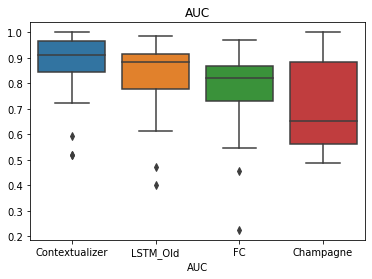

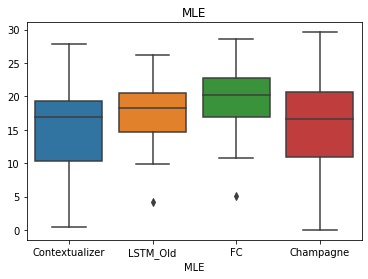

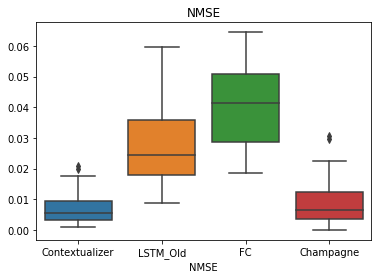

In [50]:
import seaborn as sns
names = [m.name for m in models]
xticks = (np.arange(len(models)), names)

plt.figure()
sns.boxplot(data=np.nanmean(aucs,axis=-1).T)
plt.xticks(*xticks)
plt.xlabel("AUC")
plt.title("AUC")

plt.figure()
sns.boxplot(data=np.nanmean(mles,axis=-1).T)
plt.xticks(*xticks)
plt.xlabel("MLE")
plt.title("MLE")

plt.figure()
sns.boxplot(data=np.nanmean(nmses,axis=-1).T)
plt.xticks(*xticks)
plt.xlabel("NMSE")
plt.title("NMSE")
